In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models, Model
%matplotlib inline

from data_utils import get_column_input_dict

print(tf.version.VERSION)

2021-11-01 15:59:15.929642: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


2.3.4


In [2]:
train_df = pd.read_csv('./data/train_energy.csv')
print(f'train shape: {train_df.shape}')
eval_df = pd.read_csv('./data/validate_energy.csv')
print(f'eval shape: {eval_df.shape}')
test_df = pd.read_csv('./data/test_energy.csv')
print(f'test shape: {test_df.shape}')

train shape: (351802, 314)
eval shape: (117268, 314)
test shape: (117268, 314)


In [3]:
col_dict = get_column_input_dict(train_df)
col_dict.keys()

dict_keys(['CSV_COLUMNS', 'LABEL_COLUMNS', 'STRING_COLS', 'NUMERIC_COLS', 'DEFAULTS', 'EXCLUSION_COLS'])

### Column Labels for First Record in DataFrame

In [4]:
train_df[col_dict['LABEL_COLUMNS']].values[0]

array([7415.77136515, 6121.89789123, 5896.23751387, 5859.54495006,
       5859.51165372, 6977.95782464, 5682.83018868, 5734.572697  ,
       5767.20310766, 5786.35960044, 5939.54495006, 5967.48057714,
       7323.04106548, 5998.97891232, 5918.43507214, 6028.53496115,
       5790.86570477, 6565.92674806, 5506.31520533, 5590.63263041,
       5681.74250832, 5782.77469478, 6052.14206437, 6004.46170921,
       5742.91897891, 5510.72142064, 5141.30965594, 5393.09655938])

In [5]:
def df_to_dataset(dataframe, feature_columns, label_columns, shuffle=True, batch_size=32):
    
    dataframe = dataframe.copy()
    labels = dataframe[label_columns].values
    
    for col in dataframe.columns:
        if col not in feature_columns:
            dataframe.pop(col)
    
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    
    return ds

In [6]:
def create_input_layers(numeric_cols, string_cols):
    """Creates dictionary of input layers for each feature.

    Returns:
        Dictionary of `tf.Keras.layers.Input` layers for each feature.
    """
    inputs = {
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="float32")
        for colname in numeric_cols}

    inputs.update({
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="string")
        for colname in string_cols})

    return inputs

In [7]:
def categorical_fc(name, values):
    cat_column = fc.categorical_column_with_vocabulary_list(
            key=name, vocabulary_list=values)

    return fc.indicator_column(categorical_column=cat_column)


def create_feature_columns(train_df, numeric_cols, string_cols):
    feature_columns = {
        colname : fc.numeric_column(key=colname)
           for colname in numeric_cols
    }
    
    for col in string_cols:
        feature_columns[col] = categorical_fc(col, 
            train_df[col].unique())

    return feature_columns

In [8]:
def get_model_outputs(inputs):
    
    # # simple model
    # h1 = layers.Dense(28*4, activation="relu", name="h1")(inputs)
    # h2 = layers.Dense(28*3, activation="relu", name="h2")(h1)
    # hf = layers.Dense(28*2, activation="relu", name="h3")(h2)
    
    # medium model
    h1 = layers.Dense(28*100, activation="relu", name="h1")(inputs)
    h2 = layers.Dense(28*50, activation="relu", name="h2")(h1)
    h3 = layers.Dense(28*25, activation="relu", name="h3")(h2)
    h4 = layers.Dense(28*12, activation="relu", name="h4")(h3)
    h5 = layers.Dense(28*4, activation="relu", name="h5")(h4)
    hf = layers.Dense(28*2, activation="relu", name="h6")(h5)
    
    # # large model
    # h1 = layers.Dense(28*200, activation="relu", name="h1")(inputs)
    # h2 = layers.Dense(28*100, activation="relu", name="h2")(h1)
    # h3 = layers.Dense(28*50, activation="relu", name="h3")(h2)
    # h4 = layers.Dense(28*25, activation="relu", name="h4")(h3)
    # h5 = layers.Dense(28*12, activation="relu", name="h5")(h4)
    # h6 = layers.Dense(28*6, activation="relu", name="h6")(h5)
    # h7 = layers.Dense(28*4, activation="relu", name="h7")(h6)
    # hf = layers.Dense(28*2, activation="relu", name="h8")(h7)

    # Final output is a linear activation because this is regression
    output = layers.Dense(units=28, activation="linear", name="energy")(hf) 

    return output

In [9]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_pred - y_true) ** 2))

In [10]:
NUMERIC_COLS = col_dict['NUMERIC_COLS']
STRING_COLS = col_dict['STRING_COLS']

def build_dnn_model(LR):
    """Builds simple DNN using Keras Functional API.

    Returns:
        `tf.keras.models.Model` object.
    """
    # Create input layer
    inputs = create_input_layers(NUMERIC_COLS, STRING_COLS)

    # Create feature columns
    feature_columns = create_feature_columns(train_df, NUMERIC_COLS, STRING_COLS)

    # The constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires: LayerConstructor()(inputs)
    dnn_inputs = layers.DenseFeatures(
        feature_columns=feature_columns.values())(inputs)

    # Get output of model given inputs
    output = get_model_outputs(dnn_inputs)

    # Build model and compile it all together
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    
    opt = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(optimizer=opt, loss="mse", metrics=[rmse, "mse"])
    
    return model

# print("Here is our DNN architecture so far:\n")
# model = build_dnn_model(0.001)
# print(model.summary())

In [11]:
LR = 0.00001
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset repeats, it'll wrap around
NUM_EVALS = 15  # how many times to evaluate
# Enough to get a reasonable sample, but not so much that it slows down
NUM_EVAL_EXAMPLES = 10000

trainds = df_to_dataset(
    train_df,
    col_dict['STRING_COLS'] + col_dict['NUMERIC_COLS'],
    col_dict['LABEL_COLUMNS'],
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE)

evalds = df_to_dataset(
    train_df,
    col_dict['STRING_COLS'] + col_dict['NUMERIC_COLS'],
    col_dict['LABEL_COLUMNS'],
    shuffle=False,
    batch_size=TEST_BATCH_SIZE).take(count=NUM_EVAL_EXAMPLES // 1000)

model = build_dnn_model(LR)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

logdir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, histogram_freq=1)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback])

2021-11-01 16:00:06.103357: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-01 16:00:06.124538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 16:00:06.124840: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-11-01 16:00:06.124870: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2021-11-01 16:00:06.127055: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2021-11-01 16:00:06.128139: I tensorflow/stream_executor/platform/default/d

Epoch 1/15


2021-11-01 16:00:15.552877: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11


 1/52 [..............................] - ETA: 0s - loss: 2292001280.0000 - rmse: 47874.8516 - mse: 2292001280.0000WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 5/52 [=>............................] - ETA: 1s - loss: 14011127808.0000 - rmse: 108796.1484 - mse: 14011127808.0000

2021-11-01 16:00:16.327761: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-01 16:00:16.356566: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2021-11-01 16:00:16.366663: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 659 callback api events and 659 activity events. 
2021-11-01 16:00:16.398183: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/20211101-160010/train/plugins/profile/2021_11_01_16_00_16
2021-11-01 16:00:16.412422: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/20211101-160010/train/plugins/profile/2021_11_01_16_00_16/asl-dlvm.trace.json.gz
2021-11-01 16:00:16.452429: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/20211101-160010/train/plugins/profile/2021_11_01_16_00_16
2021-11-01 16:00:16.458881: I tensorflow/core/

52/52 [==============================] - 5s 97ms/step - loss: 10323079168.0000 - rmse: 80642.9453 - mse: 10323079168.0000 - val_loss: 17484431360.0000 - val_rmse: 128885.7109 - val_mse: 17484431360.0000
Epoch 2/15
52/52 [==============================] - 3s 57ms/step - loss: 11893751808.0000 - rmse: 79819.7812 - mse: 11893751808.0000 - val_loss: 12382577664.0000 - val_rmse: 108188.5469 - val_mse: 12382577664.0000
Epoch 3/15
52/52 [==============================] - 3s 56ms/step - loss: 8982706176.0000 - rmse: 63584.2969 - mse: 8982706176.0000 - val_loss: 10106294272.0000 - val_rmse: 97871.7891 - val_mse: 10106294272.0000
Epoch 4/15
52/52 [==============================] - 3s 57ms/step - loss: 9250257920.0000 - rmse: 73610.6797 - mse: 9250257920.0000 - val_loss: 8569673728.0000 - val_rmse: 90247.3906 - val_mse: 8569673728.0000
Epoch 5/15
52/52 [==============================] - 3s 56ms/step - loss: 9185864704.0000 - rmse: 73822.3984 - mse: 9185864704.0000 - val_loss: 7886582272.0000 - va

Text(0.5, 0, 'Epoch')

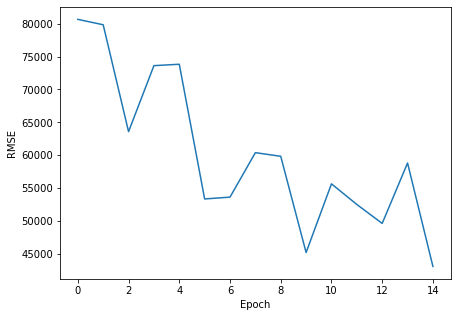

In [12]:
fig = plt.figure(figsize=(7, 5))
sns.lineplot(x=range(len(history.history['rmse'])), y=history.history['rmse'])
plt.ylabel('RMSE')
plt.xlabel('Epoch')
#plt.title(f'Batch Size = {batch_size}, LR = {LR}, Model = {model_desc}')

### This is Markdown